# Convolution as Matrix Multiplication


## What is the purpose?

Convolution over an image channel is the operation of sliding a filter over that image's channel, multiplying the values that align, and summing them. It is usually programmed using loops to represent the sliding of the filter of the image.

However, it is possible to compute the convolution as a matrix multiplication instead by converting the filter into a Toeplitz matrix, the image channel into a vector, multiplying them, and then reshaping the resultant vector into a matrix.

## Why do we do that?

There are many efficient matrix multiplication algorithms, so using them we can have an efficient implementation of convolution operation.

## What is in this document?

Mathematical and algorithmic explanation of this process with Python.

## What is a Toeplitz matrix?
Toeplitz matrix is a matrix in which each values along the main diagonal and sub diagonals are constant. Matrix $G$ is an example:

$$\begin{pmatrix}
	2 & -1 & 0 & \cdots & \cdots & \cdots & \cdots & 1\\
	5 & 2 & -1 & 0 & & & & \vdots\\
	-8 & 5 & 2 & -1 & \ddots & & & \vdots\\
	\vdots & -8 & \ddots & \ddots & \ddots & \ddots & & \vdots\\
	\vdots & & \ddots & \ddots & \ddots & \ddots & 0 & \vdots\\
	\vdots & & & \ddots & 5 & 2 & -1 & 0\\
	\vdots & & & & -8 & 5 & 2 & -1\\
	1 & \cdots & \cdots  & \cdots & \cdots & -8 & 5 & 2\\
	\end{pmatrix}$$
    
In a $N \times N$ matrix, its elements are determined by a ($2N -1$) length sequence
	 $$\{t_n | -(N-1) \le n \le (N-1)\}$$

So given a sequence $t_n$ we can create a Toeplitz matrix by following these steps:    
 - put the sequence in the first column of the matrix.
 - shift it and put it in the next column. When shifting, the last element disappears and a new element of the sequence appears. If there is no such an element, put zero in that location.

specifically: $T(m,n)=t_{m-n}$

$$\begin{pmatrix}
	t_0 & t_{-1} & t_{-2} & \cdots & \cdots & \cdots & \cdots & t_{-(N-1)}\\
	t_1 & t_0 & t_{-1} & t_{-2} & & & & \vdots\\
	t_2 & t_1 & t_0 & t_{-1} & \ddots & & & \vdots\\
	\vdots & t_2 & \ddots & \ddots & \ddots & \ddots & & \vdots\\
	\vdots & & \ddots & \ddots & \ddots & \ddots & t_{-2} & \vdots\\
	\vdots & & & \ddots & t_1 & t_0 & t_{-1} & t_{-2}\\
	\vdots & & & & t_2 & t_1 & t_0 & t_{-1}\\
	t_{(N-1)} & \cdots & \cdots  & \cdots & \cdots & t_2 & t_1 & t_0\\
	\end{pmatrix}$$

Be aware that when we are working with sequences that are defined just for $n \ge 0$ values for $t_n$ when $n \le 0$ should be considered as $0$. For example $4 \times 4$ Toeplitz matrix for the sequence $f[n]=[1,2,3]$ will be:

$$\begin{pmatrix}
	1 & 0 & 0 & 0\\
	2 & 1 & 0 & 0\\
	3 & 2 & 1 & 0\\
	0 & 3 & 2 & 1 \\
	\end{pmatrix}$$
    
<a id="doubly_blocked"></a>

## One more definition: Doubly Blocked Toeplitz matrix
In the matrix $A$, all $A_{ij}$ are matrices. If the structure of $A$, with respects to its sub-matrices is Toeplitz, then matrix $A$ is called $\textbf{Block-Toeplitz}$.

$$\begin{pmatrix}
	A_{11} & A_{12} & \cdots & A_{1N}\\
	A_{21} & A_{22} & \cdots & A_{2N}\\
	\vdots & \vdots & \vdots & \vdots \\
	A_{M1} & A_{M2} & \cdots & A_{MN}\\
	\end{pmatrix}$$

If each individual $A{ij}$ also is a Toeplitz matrix then $A$ is called $\textbf{Doubly Blocked Toeplitz}$.

## Is this Convolution or Cross Correlation?

The word *convolution* in the deep learning literature is often used instead of *cross-correlation*.

**The method explained here performs the convolution, not correlation.**

## Step by Step
   

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from scipy import signal, datasets, ndimage, sparse
import matplotlib.pyplot as plt

Let's explain the algorithm step by step using an example.

### Input and Filter

The input matrix that the filter will be convolved with is:

$$I =
	\begin{bmatrix}
	1 & 2 & 3 \\
	4 & 5 & 6 \\
	\end{bmatrix}$$

And let the filter be:

$$F =
	\begin{bmatrix}
	10 & 20 \\
	30 & 40 \\
	\end{bmatrix}$$

In [2]:
# input signal
I = np.array([[1, 2, 3], [4, 5, 6]])
print('I: ', I.shape)
print(I)

 # filter
F = np.array([[10, 20], [30, 40]])
print('F: ',F.shape)
print(F)

I:  (2, 3)
[[1 2 3]
 [4 5 6]]
F:  (2, 2)
[[10 20]
 [30 40]]


<a id="output-size"></a>

### Calculate the final output size
If the input signal is $m_1 \times n_1$ and filter is $m_2 \times n_2$ the size of the convolution will be

$$(m_1 + m_2 -1) \times (n_1 + n_2 -1)$$

This is the size of full discrete linear convolution. One might just use some part of the output based on the application. For example in deep learning literature you can use "valid" or "same" as your padding mode. In these case just parts of the full output is used.

Proper zero padding should be done to get the correct output. Zero padding is the next step.  

In [3]:
# number columns and rows of the input
I_row_num, I_col_num = I.shape

# number of columns and rows of the filter
F_row_num, F_col_num = F.shape

#  calculate the output dimensions
output_row_num = I_row_num + F_row_num - 1
output_col_num = I_col_num + F_col_num - 1
print('output dimension:', output_row_num, output_col_num)


output dimension: 3 4


### Zero-pad the filter matrix
The next step is to zero pad the filter to make it the same size as the output. Zeros should be added to the top and right sides of the filter.

<img src="https://github.com/pablordoricaw/conv_as_mm/blob/main/images/3.png?raw=1" alt="Zero padding" title="Zero padded F" width="300"/>

In [4]:
# zero pad the filter
F_zero_padded = np.pad(F, ((0, output_row_num - F_row_num),
                           (0, output_col_num - F_col_num)),
                        'constant', constant_values=0)
print(f"F_zero_padded:\n{F_zero_padded}")

F_zero_padded:
[[10 20  0  0]
 [30 40  0  0]
 [ 0  0  0  0]]


### Toeplitz matrix for each row of the zero-padded filter
For each row of the zero-padded filter `F_zero_padded` create a Toeplitz matrix and store them in a list. Matrix created using the last row goes to the first cell of this list.

<img src="https://github.com/pablordoricaw/conv_as_mm/blob/main/images/4.png?raw=1" alt="Toeplitz matrix for each row of the zero-padded filter" title="Toeplitz matrix for each row of the zero-padded filter" width="500"/>

**Why these matrices have three columns? Why not two or 5? What is the rule here?**
The important point is that the number of columns of these generated Toeplitz matrices should be same as the number of columns of the input (I) matrix.

In the code, I am using `toeplitz()` function from `scipy.linalg library`. One row of the $F$ is passed to this function and the function puts it as the first column of the its output matrix. Then as it is explained before, this vector should be shifted down and be putted in the second column. For this function, in addition to the first column, we need to define the first row, otherwise, the output of the function would be different than what we expect here. The first element of this first row is same as the first element of the first column, and the rest of the elements should be set to zero. (I know that it doesn't make sense :D read it twice and look at the code)

In [5]:
# use each row of the zero-padded F to creat a toeplitz matrix.
# Number of columns in this matrices are same as numbe of columns of input signal
toeplitz_list = []
for row in F_zero_padded: # iterate from last row to the first row
    c = np.r_[row[0], np.zeros(I_col_num - 1)]
    toeplitz_m = toeplitz(row, c) # this function is in scipy.linalg library
    toeplitz_list.append(toeplitz_m)
toeplitz_list

[array([[10.,  0.,  0.],
        [20., 10.,  0.],
        [ 0., 20., 10.],
        [ 0.,  0., 20.]]),
 array([[30.,  0.,  0.],
        [40., 30.,  0.],
        [ 0., 40., 30.],
        [ 0.,  0., 40.]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])]

### Create doubly blocked toeplitz matrix
Now all these small toeplitz matrices should be arranged in a big doubly blocked toepltiz matrix [as described in this section](#doubly_blocked).

In this example $F_0, F_1, F_2$ are corresponding toeplitz matrices for each row of the filter. They should be filled in the doubly blocked toeplitz matrix in this way:

$$doubly \ blocked =
	\begin{bmatrix}
	F_0 & 0 \\
	F_1 & F_0 \\
	F_2 & F_1 \\
	\end{bmatrix}$$
    
Number of columns in this symbolic matrix should be same as the number of rows in the input signal I.\\
	The following code stores the indexes of $F_0, F_1, F_2$ in this format. This will be used to fill out the doubly blocked toepltiz matrix later.

In [6]:
# doubly blocked toeplitz indices:
#  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
c = range(1, F_zero_padded.shape[0]+1)
r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
doubly_indices = toeplitz(c, r)
print('doubly indices \n', doubly_indices)

doubly indices 
 [[1 0]
 [2 1]
 [3 2]]


Now let's fill in the doubly blocked toepltiz matrix. Following code does this part:

In [122]:
# create doubly blocked matrix with zero values
toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
h = toeplitz_shape[0]*doubly_indices.shape[0]
w = toeplitz_shape[1]*doubly_indices.shape[1]
doubly_blocked_square_shape = (h, w)

# construct as a SciPy lil_array which is a sparse structure for constructing
# sparse arrays incrementally.
doubly_blocked = sparse.lil_array(doubly_blocked_square_shape)

# tile toeplitz matrices for each row in the doubly blocked matrix
b_h, b_w = toeplitz_shape # height and widths of each block
for i in range(doubly_indices.shape[0]):
    for j in range(doubly_indices.shape[1]):
        start_i = i * b_h
        start_j = j * b_w
        end_i = start_i + b_h
        end_j = start_j + b_w
        doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

# transform to a SciPy csr_array sparse structure which which is most useful for
# fast arithmetic, vector products, and slicing by row.
doubly_blocked = sparse.csr_array(doubly_blocked)

print(f"doubly_blocked_square: {doubly_blocked.shape} type={type(doubly_blocked)}\n{doubly_blocked.toarray()}")

doubly_blocked_square: (12, 6) type=<class 'scipy.sparse._csr.csr_array'>
[[10.  0.  0.  0.  0.  0.]
 [20. 10.  0.  0.  0.  0.]
 [ 0. 20. 10.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.  0.]
 [30.  0.  0. 10.  0.  0.]
 [40. 30.  0. 20. 10.  0.]
 [ 0. 40. 30.  0. 20. 10.]
 [ 0.  0. 40.  0.  0. 20.]
 [ 0.  0.  0. 30.  0.  0.]
 [ 0.  0.  0. 40. 30.  0.]
 [ 0.  0.  0.  0. 40. 30.]
 [ 0.  0.  0.  0.  0. 40.]]


For this example the result will be the following matrix. I've colored parts of the matrix that is related to each of the small toeplitz matrices.

<img src="https://github.com/pablordoricaw/conv_as_mm/blob/main/images/6.png?raw=1" alt="doubly blocked toeplitz" title="doubly blocked toeplitz matrix" width="500">

### Convert the input matrix to a vector
Now that the filter has converted to a doubly blocked Toeplitz matrix, we just need to convert the input signal to a vector and multiply them.

All the rows of the input should be transposed to a column vector and stacked on top of each other. The last row goes first!

<img src="https://github.com/pablordoricaw/conv_as_mm/blob/main/images/7.png?raw=1" alt="vectorized input" title="vectorized input" width="400">

The following function does the vectorization. I am sure that there are much simpler ways to do so, but for the purpose of explanation, this function is implemented in this way.

In [124]:
# call the function
vectorized_I = I.flatten()
print(f"vectorized_I: {vectorized_I.shape} type={type(vectorized_I)}\n{vectorized_I}")

vectorized_I: (6,) type=<class 'numpy.ndarray'>
[1 2 3 4 5 6]


### Multiply doubly blocked toeplitz matrix with vectorized input signal
Do the matrix multiplication between these two matrices. In this example, the doubly blocked Toeplitz matrix is $ 12 \times 6$ and the vectorized input is $6 \times 1$ so the result of the multiplication is $12 \times 1$.

In [125]:
result_vector = doubly_blocked @ vectorized_I
print(f"result_vector: {result_vector.shape} type={type(result_vector)}\n{result_vector}")

result_vector: (12,) type=<class 'numpy.ndarray'>
[ 10.  40.  70.  60.  70. 230. 330. 240. 120. 310. 380. 240.]


### Last step: reshape the result to a matrix form
From section [output_size](#output-size) we know that the output of the convolution should be $(m_1 + m_2 -1) \times (n_1 + n_2 -1)$. First $(n_1 + n_2 -1)$ elements in the output vector form the last row of the final output and the second $(n_1 + n_2 -1)$ elements go to the second-to-last row of the output matrix. Repeat this process to form the final output matrix.

In this example $n_1 = 3$ and $n_2 = 2$, so every 4 element goes to one row of the output matrix.

<img src="https://github.com/pablordoricaw/conv_as_mm/blob/main/images/8.png?raw=1" alt="reshape the output" width="550">

Following function performs this step:

In [126]:
# reshape the raw rsult to desired matrix form
out_shape = (output_row_num, output_col_num)
my_output = np.reshape(result_vector, out_shape)

print('Result of implemented method: \n', my_output)

Result of implemented method: 
 [[ 10.  40.  70.  60.]
 [ 70. 230. 330. 240.]
 [120. 310. 380. 240.]]


### Compare the result with other convolution methods
We can compare the output of this method with `convolve2d()` function from the `scipy` library.

In [127]:
lib_output = signal.convolve2d(I, F, "full")
print('Result using signal processing library\n', lib_output)

assert(my_output.all() == lib_output.all())

Result using signal processing library
 [[ 10  40  70  60]
 [ 70 230 330 240]
 [120 310 380 240]]


As you can see the result on the same I and F matrices is same as the result of the implemented method. The parameter "full" is passed to the `signal.convolve2d()` function to get the full convolution results.

### Put Everything Together

In [128]:
def conv_as_mmult(I, F, mode="full"):
    """
    Perform 2D convolution using matrix multiplication.

    This function implements 2D convolution by converting the operation into a matrix
    multiplication problem. It supports 'full', 'same', and 'valid' convolution modes.

    Parameters:
    -----------
    I : numpy.ndarray
        Input 2D array (image) to be convolved.
    F : numpy.ndarray
        2D convolution kernel (filter).
    mode : str, optional
        A string indicating the size of the output:
        - 'full': The output is the full discrete linear convolution (default).
        - 'same': The output is the same size as the input I, centered
                  with respect to the 'full' output.
        - 'valid': The output consists only of those elements that do not
                   rely on zero-padding.

    Returns:
    --------
    numpy.ndarray
        The 2D convolution of I and F, with size depending on the mode:
        - 'full': (I.shape[0] + F.shape[0] - 1, I.shape[1] + F.shape[1] - 1)
        - 'same': Same size as input I
        - 'valid': (I.shape[0] - F.shape[0] + 1, I.shape[1] - F.shape[1] + 1)

    Raises:
    -------
    ValueError
        If an invalid mode is specified.

    Notes:
    ------
    This function uses the Toeplitz matrix approach to convert the 2D convolution
    into a matrix multiplication problem. It constructs a doubly blocked Toeplitz
    matrix from the filter F and then performs matrix multiplication with the
    vectorized input I.

    The implementation is equivalent to scipy.signal.convolve2d but uses a
    different algorithmic approach.

    Examples:
    ---------
    >>> import numpy as np
    >>> I = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> F = np.array([[1, 0], [0, 1]])
    >>> conv_as_mmult(I, F, mode='full')
    array([[1, 2, 3, 0],
           [4, 6, 5, 3],
           [7, 8, 9, 6],
           [0, 7, 8, 9]])
    >>> conv_as_mmult(I, F, mode='same')
    array([[1, 2, 3],
           [4, 6, 5],
           [7, 8, 9]])
    >>> conv_as_mmult(I, F, mode='valid')
    array([[6, 5],
           [8, 9]])
    """

    if mode != "full" and mode != "valid" and mode != "same":
        raise ValueError("mode should be 'full', 'valid' or 'same'")

    I_row_num, I_col_num = I.shape
    F_row_num, F_col_num = F.shape

    #  calculate the output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1

    # zero pad the filter
    F_zero_padded = np.pad(F, ((0, output_row_num - F_row_num),
                               (0, output_col_num - F_col_num)),
                                'constant', constant_values=0)

    toeplitz_list = []
    for row in F_zero_padded:
        c = np.zeros(I_col_num)
        c[0] = row[0]
        toeplitz_m = toeplitz(row, c) # this function is in scipy.linalg library
        toeplitz_list.append(toeplitz_m)

    # doubly blocked toeplitz indices:
    # this matrix defines which toeplitz matrix from toeplitz_list goes to which
    # part of the doubly blocked
    c = range(1, F_zero_padded.shape[0] + 1)
    r = np.r_[c[0], np.zeros(I_row_num - 1, dtype=int)]
    doubly_indices = toeplitz(c, r)

    # create doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one Toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]

    doubly_blocked_shape = (h, w)

    # construct as a SciPy lil_array which is a sparse structure for constructing
    # sparse arrays incrementally.
    doubly_blocked = sparse.lil_array(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # height and widths of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]
    # transform to a SciPy csr_array sparse structure which which is most useful for
    # fast arithmetic, vector products, and slicing by row.
    doubly_blocked = sparse.csr_array(doubly_blocked)

    vectorized_I = I.flatten()

    result_vector = doubly_blocked @ vectorized_I
    full_result = np.reshape(result_vector, (output_row_num, output_col_num))

    if mode == 'same':
        start_row = (F_row_num - 1) // 2
        start_col = (F_col_num - 1) // 2
        full_result = full_result[start_row:start_row+I_row_num, start_col:start_col+I_col_num]
    elif mode == 'valid':
        full_result = full_result[F_row_num-1:I_row_num, F_col_num-1:I_col_num]

    return full_result

### Test on bigger examples

Now lets test with bigger input and filter matrices and compare out results with results from singla processing function

In [129]:
# test on different examples

# fill I an F with random numbers
I = np.random.randn(10, 13)
F = np.random.randn(30, 70)

my_result = conv_as_mmult(I, F)

lib_result = signal.convolve2d(I, F, mode="full")

assert(my_result.all() == lib_result.all())

# Cross-Correlation as Matrix Multiplication

Since cross-correlation is the same operation as convolution where the only difference is the filtered is flipped.

We can use the `conv_as_mm()` function to compute cross-correlation by performing a horizontal and vertical flip on the filter before passing it on to the function.

In [103]:
# fill I an F with random numbers
# input signal
I = np.array([[1, 2, 3], [4, 5, 6]])
print('I: ', I.shape)
print(I)
print()

 # filter
F = np.array([[10, 20], [30, 40]])
F_flipped = np.flip(F)
print('F_flipped: ', F_flipped.shape)
print(F_flipped)

print()

my_result = conv_as_mmult(I, F_flipped)
print('Result of implemented method: \n', my_result)
print()

lib_result = signal.correlate2d(I, F, mode="full")
print('Result using signal processing library\n', lib_result)

assert(my_result.all() == lib_result.all())

I:  (2, 3)
[[1 2 3]
 [4 5 6]]

F_flipped:  (2, 2)
[[40 30]
 [20 10]]

Result of implemented method: 
 [[ 40. 110. 180.  90.]
 [180. 370. 470. 210.]
 [ 80. 140. 170.  60.]]

Result using signal processing library
 [[ 40 110 180  90]
 [180 370 470 210]
 [ 80 140 170  60]]


## SciPy correlate2d() Example

The following example is from SciPy's `correlate2d()` function documentation. The cross-correlation is used to find a raccoon's eye (template) in the raccoon's face picture.

In [120]:
rng = np.random.default_rng()
raccoon = datasets.face(gray=True) - datasets.face(gray=True).mean()

face = ndimage.zoom(raccoon[30:500, 400:950], 0.5)  # extract the face

template = np.copy(face[135:165, 140:175])  # right eye
template -= template.mean()

noisy_face = face + rng.standard_normal(face.shape) * 50  # add noise

corr = signal.correlate2d(noisy_face, template, boundary='symm', mode='same')
y, x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match

I've modified the portion of SciPy's example that displays the images to in my opinion better illustrate what is going on.

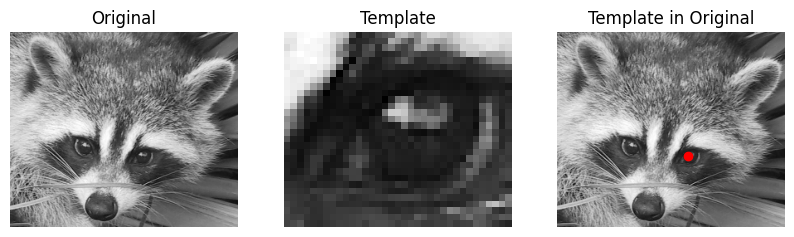

In [121]:
fig, (ax_orig, ax_template, ax_orig_dot) = plt.subplots(1, 3, figsize=(10, 3))

ax_orig.imshow(face, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()

ax_template.imshow(template, cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()

ax_orig_dot.imshow(face, cmap='gray')
ax_orig_dot.set_title('Template in Original')
ax_orig_dot.plot(x, y, 'ro')
ax_orig_dot.set_axis_off()

fig.show()

We can reproduce SciPy's example using the `conv_as_mmult()` function by flipping the template before passing it to the function.



In [106]:
rng = np.random.default_rng()
raccoon = datasets.face(gray=True) - datasets.face(gray=True).mean()

face = ndimage.zoom(raccoon[30:500, 400:950], 0.5)  # extract raccoon's face
template = np.copy(face[135:165, 140:175])  # right eye
template -= template.mean()

### Flip template
template_flipped = np.flip(template)
###

noisy_face = face + rng.standard_normal(face.shape) * 50  # add noise

corr = conv_as_mmult(noisy_face, template_flipped, mode='same')
y, x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match

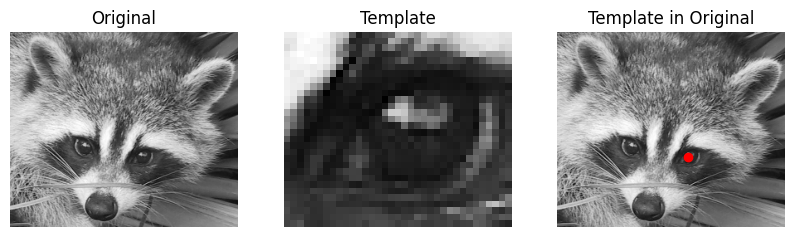

In [107]:
fig, (ax_orig, ax_template, ax_orig_dot) = plt.subplots(1, 3, figsize=(10, 3))

ax_orig.imshow(face, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()

ax_template.imshow(template, cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()

ax_orig_dot.imshow(face, cmap='gray')
ax_orig_dot.set_title('Template in Original')
ax_orig_dot.plot(x, y, 'ro')
ax_orig_dot.set_axis_off()

fig.show()

  # References

 - The steps explained here are based on Christophoros Nikou's slides on **Filtering in the Frequency Domain (Circulant Matrices and Convolution)** (http://www.cs.uoi.gr/~cnikou/Courses/Digital_Image_Processing/2010-2011/Chapter_04c_Frequency_Filtering_(Circulant_Matrices).ppt)
 - This post on https://dsp.stackexchange.com/questions/35373/convolution-as-a-doubly-block-circulant-matrix-operating-on-a-vector/35376#35376}{dsp.stackexchange also helped in understanding this algorithm.